## Bayes Linear Regression Brute Force vs Analytical 

**Goal:** This notebook introduces the Bayesian approach on the example of linear regression.

**Usage:** The idea of the notebook is that you try to understand the provided code by running it, checking the output and playing with it by slightly changing the code and rerunning it.

**Dataset:** Artificial Data

**Content:** 
* Creation of the artificial data
* The MaxLike solution
* The CPD $p(y|x,a,b)$ for abitrary values of $a, b$ using a binning approch 
* The Likelihood $p(a,b)$ for values $a, b$ using a binning approch 
* The resulting CPD $p(y|x)$ combining the CPD $p(y|x,a,b)$ and the likelihood $p(a,b)$
* An analytical solution

In [1]:
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
    %tensorflow_version 2.x
except:
    IN_COLAB = False

In [2]:
import tensorflow as tf
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0  running in colab?:  False


In [3]:
if IN_COLAB:
    !pip install tensorflow_probability==0.8.0

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp

sns.reset_defaults()
#sns.set_style('whitegrid')
sns.set_context(context='talk',font_scale=0.7)
plt.style.use('default') 
plt.rcParams.update({'font.size': 15}) 

%matplotlib inline

tfd = tfp.distributions
print("TFB Version", tfp.__version__)
print("TF  Version",tf.__version__)

TFB Version 0.8.0
TF  Version 2.0.0


In [5]:
# Parameters
sigma=3 #Spread for the artificial data 
xmin = -5;xmax = +5;ymin=-40;ymax=40;
nbins_c=30; 

## Creation of the artificial data set

We create an artificial data set, for which we assume that it is generated from linear regression.

In [6]:
save = True
np.random.seed(2)
num = 4
#x = np.random.normal(0,1,(num,1)) 
x = np.linspace(-2,2,num=num).reshape((num,1))
y = 2 * x[:,0] - 1 + 1.*np.random.normal(0,sigma,num) 
if save:
        d = np.transpose(np.vstack((x[:,0],y)))
        np.savetxt('nb_ch07_lr_artifical{}.csv'.format(num), d, delimiter=',', header='x,y',comments="",fmt='%.4e'); 

## MaxLike estimation of the coefficients 

We use a standard linear regression approch to estimate the data.

In [7]:
from sklearn import linear_model
regr = linear_model.LinearRegression(fit_intercept=True)
regr.fit(x,y)
# The coefficients
a_ml = regr.coef_
b_ml = regr.intercept_
print('Coefficients: \n', a_ml)
print('Coefficients: \n', b_ml)

Coefficients: 
 [2.92051026]
Coefficients: 
 -1.726712471421449


## Plotting

The parameters $a$ for the slope and $b$ for the intercept, are given by the regression coefficients. We assume that $\sigma$ is known. In the plot, we also show the 2.5% and 97.5% percentile. 

<Figure size 432x432 with 0 Axes>

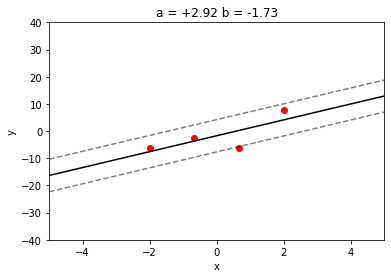

In [8]:
plt.figure(figsize=(6,6))
def make_ml_plot(a,b, ax,f):
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('a = {:+.2f} b = {:+.2f}'.format(a,b))  
    ax.plot([xmin, xmax], [a*xmin+b, a*xmax+b], color='black')
    ax.plot([xmin, xmax], [a*xmin+b+2*sigma, a*xmax+b+1.96*sigma], linestyle='dashed', alpha=0.5,color='black')
    ax.plot([xmin, xmax], [a*xmin+b-2*sigma, a*xmax+b-1.96*sigma], linestyle='dashed', alpha=0.5,color='black')
    ax.scatter(x,y, marker='o', color='r')

f,ax = plt.subplots(1,1)
a = a_ml[0];b = b_ml
make_ml_plot(a,b,ax,f)

## Predictive Distribution $p(y|x,a,b)$ given $a,b$

Calculation of the predictive distribution $p(y|x,a,b)$ for a bunch of values x, and y given a fixed set of parameters (a,b). We evaluate the solutions on a grid with `nbins_c`.

In [9]:
def pre_distribution(a,b):
    """
        Calculates the predictive distribution p(y|(a,b)) for a, b
        Note that this calculation is done on bins. 
        Therefore the x and y values for the bins are also returned.
    """
    canvas0 = np.zeros((nbins_c, nbins_c), dtype=np.float32) #The complete img
    xi = np.zeros((nbins_c, nbins_c), dtype=np.float32)
    yi = np.zeros((nbins_c, nbins_c), dtype=np.float32)
    for j,x_ in enumerate(np.linspace(xmin, xmax, nbins_c)):
        py = tfd.Normal(loc=a*x_+b,scale=sigma)
        for i,y_ in enumerate(np.linspace(ymin, ymax, nbins_c)):
            xi[i,j] = x_
            yi[i,j] = y_
            canvas0[i,j] = py.prob(y_)
    # This part is a bit tricky. The sum over y for a fixed a should be 1. 
    # However, due to finite bin width this is not the case.
    # We renormalize
    return canvas0/ np.sum(canvas0,axis=0), xi, yi

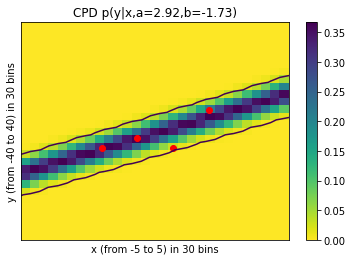

In [10]:
import scipy
def plot_cpd(a,b,ax0,pxy_ml,xi,yi):
    cmap = plt.get_cmap('viridis_r',)
    im = ax0.pcolormesh(xi, yi, pxy_ml, cmap=cmap)
    ax0.contour(xi, yi, pxy_ml,[scipy.stats.norm(0, sigma).pdf(1.96*sigma)])
    fig.colorbar(im, ax=ax0)
    ax0.scatter(x,y, marker='o',c='r')
    ax0.set_xlabel('x (from {} to {}) in {} bins'.format(xmin, xmax, nbins_c))
    ax0.set_ylabel('y (from {} to {}) in {} bins'.format(ymin, ymax, nbins_c))
    ax0.set_title('CPD p(y|x,a={},b={})'.format(round(a,2),round(b,2)))
    ax0.set_xticks([], [])
    ax0.set_yticks([], [])

a = a_ml
b = b_ml
pxy_ml,xi,yi = pre_distribution(a, b)
fig, ax0 = plt.subplots(nrows=1)
plot_cpd(a_ml[0],b_ml,ax0,pxy_ml,xi,yi)

We can also have a look at the predictive distribution at parameters, not corresponding to the maximum likelihood values. 

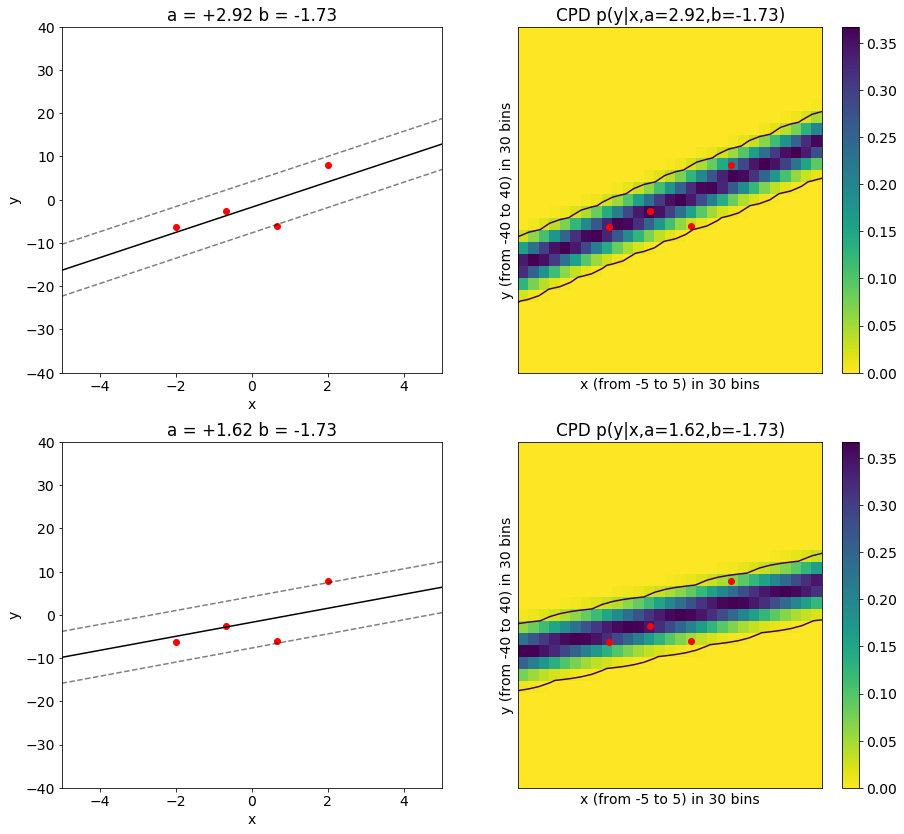

In [11]:
plt.rcParams.update({'font.size': 14}) 
f,ax = plt.subplots(2,2, figsize=(15,14)) 
a = a_ml[0];b = b_ml
make_ml_plot(a,b,ax[0][0],f)
plot_cpd(a,b_ml,ax[0][1],pxy_ml,xi,yi)

# Not the maximum likelihood values
a = a_ml[0]/1.8;b = b_ml
pxy_ml,xi,yi = pre_distribution(a, b)
make_ml_plot(a,b,ax[1][0],f)
plot_cpd(a,b,ax[1][1],pxy_ml,xi,yi)

plt.savefig('ch07_lr.pdf')

Text(0.5, 0, 'y [in bins]')

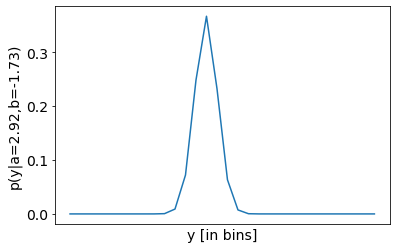

In [12]:
plt.plot(pxy_ml[:,10]) #A slice through the distributions looks quite Gaussian
plt.xticks([], [])
plt.ylabel('p(y|a={},b={})'.format(round(a_ml[0],2),round(b,2)))
plt.xlabel('y [in bins]')

## Combining serveral predictive distributions

As discussed in the main text. We average many predictive distributions. 

$$
    p(y|x,(a,b)) = Norm(y=ax+b,\sigma=3)
$$

given parameters $(a,b)$ and weight them according to their normalized likelihood $p(a,b)$. So that we get the final predictivedistributions as:

$$
    p(y|x) = \sum_a \sum_b p(a,b) \cdot p(y|x,(a,b))
$$

We evaluate the sum at `nbins` different values for $a$ and also for $b$

We start to calculate the (unnormalized) likelihood $lik(a,b)$ as:

$$
    lik(a,b) = \prod_i^N N(y_i;a*x_i + b,\sigma = 3) 
$$

In [13]:
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
ytensor = y.reshape([len(y),1]) #A

@tf.function
def unnormalized_likehihood(w):#B
    y_prob = tfd.Independent( #C
        tfd.Normal(loc=x*w[0]+w[1], scale=sigma)
    )
    return tf.reduce_prod(y_prob.prob(ytensor))

#A y is now a 2-dimensional tensor
#B w holds the two random variables a=w[0] and b=w[1] in the Tensor w
#C Definition of the likelihood (independent Gaussian with fixed sigma)
#D Calculation of the log-posterior as defined in eq.log_post

We normalize the likelihood to sum up to 1. 

In [14]:
from tqdm import tqdm
nbins = 30
bmin=-10;bmax=8
amin=-3;amax=8
ai, bi = np.mgrid[amin:amax:nbins*1j, bmin:bmax:nbins*1j] #wtf is j?
ws = np.vstack([ai.flatten(), bi.flatten()])
unlike = np.zeros((nbins*nbins))
for i in tqdm(range((nbins*nbins))):
    w_tf = tf.Variable([[ws[0,i]],[ws[1,i]]],dtype=tf.float32)
    unlike[i] = unnormalized_likehihood(w_tf)
unlike = unlike.reshape(ai.shape)
norm_like = unlike / np.sum(unlike) #<-- We normalize

100%|██████████| 900/900 [00:01<00:00, 704.88it/s]


We plot the normalized likelihood. 

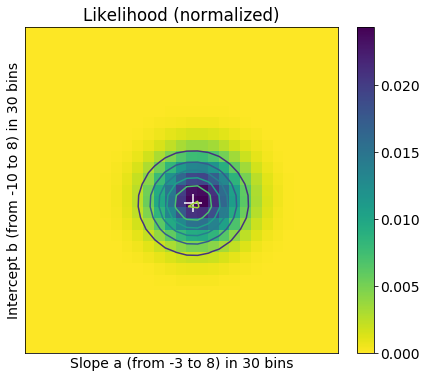

In [15]:
fig, ax0 = plt.subplots(nrows=1,figsize=(7,6))
cmap = plt.get_cmap('viridis_r')
im = plt.pcolormesh(ai, bi, norm_like, shading='none',cmap=cmap)
fig.colorbar(im, ax=ax0)
plt.contour(ai, bi, norm_like)
plt.scatter(a_ml, b_ml, color='w', marker='+',s=333)
plt.xticks([], [])
plt.yticks([], [])
plt.xlabel('Slope a (from {} to {}) in {} bins'.format(amin, amax, nbins))
plt.ylabel('Intercept b (from {} to {}) in {} bins'.format(bmin, bmax, nbins))
plt.title('Likelihood (normalized)')
plt.savefig('ch07_lrlik.pdf')

With the normalized likelihood, which is defined on a discrete grid. We can create a functions, which gives us the normalized likelihood on continious values.

In [15]:
def toBin(a, amin, amax):
    a = np.clip(a, amin, amax)
    return int(0.99999*(a - amin)/(amax-amin) * nbins)

def getProb(a,b):
    return norm_like[toBin(a,amin,amax),toBin(b,bmin,bmax)]

Let's evaluate this function at a few values. First, we try the maximum likelihood estimates a_ml and b_ml. The function should be maximal at those values.

In [16]:
getProb(a_ml,b_ml),getProb(a_ml[0] / 1.8, b_ml * 1)

(0.02433014951708463, 0.00975107263868428)

Now having the normalized likelihood at different values. Let's evaluate the predictive distribution by averaging over all possible values of a and b and weight them according to their probability.  
$$
    p(y|x,D) = \sum_a \sum_b p(y|x,(a,b))p((a,b)|D)
$$

#### Listing 7.1 The code corresponding to equation 7.e_mar

In [17]:
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
pyx = np.zeros((nbins_c, nbins_c), dtype=np.float32) #A 
for a in tqdm(np.linspace(amin, amax, nbins)): #B
    for b in np.linspace(bmin, bmax, nbins):
        p = getProb(a,b) #C
        pyx += pre_distribution(a,b)[0] * getProb(a,b) 

#A Start with a blank canvas
#B Loop over "all" parameters a 
#C Get the probability for the parameters a and b, given the data

100%|██████████| 30/30 [03:15<00:00,  6.51s/it]


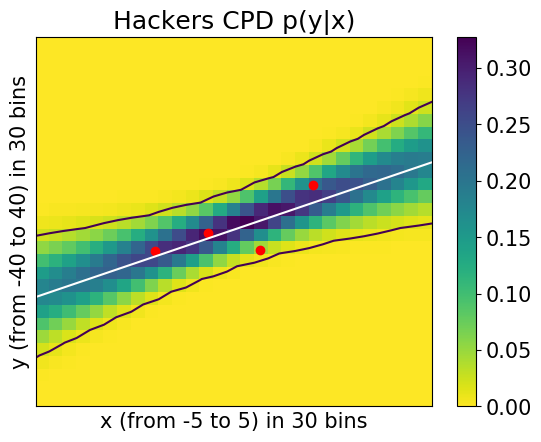

In [88]:
#plt.figure(figsize=(6,6))
fig, ax0 = plt.subplots(nrows=1)
cmap = plt.get_cmap('viridis_r',)
im = plt.pcolormesh(xi, yi, pyx, cmap=cmap)
plt.contour(xi, yi, pyx,[scipy.stats.norm(0, sigma).pdf(2*sigma)])
fig.colorbar(im, ax=ax0)
plt.scatter(x,y, marker='o',c='r')
plt.plot([xmin, xmax], [a_ml*xmin+b_ml, a_ml*xmax+b_ml], color='w', alpha = 1)

plt.title('Hackers CPD p(y|x)')
plt.xlabel('x (from {} to {}) in {} bins'.format(xmin, xmax, nbins_c))
plt.ylabel('y (from {} to {}) in {} bins'.format(ymin, ymax, nbins_c))
plt.xticks([], [])
plt.yticks([], [])

plt.savefig('ch07_f_mar_1.pdf')

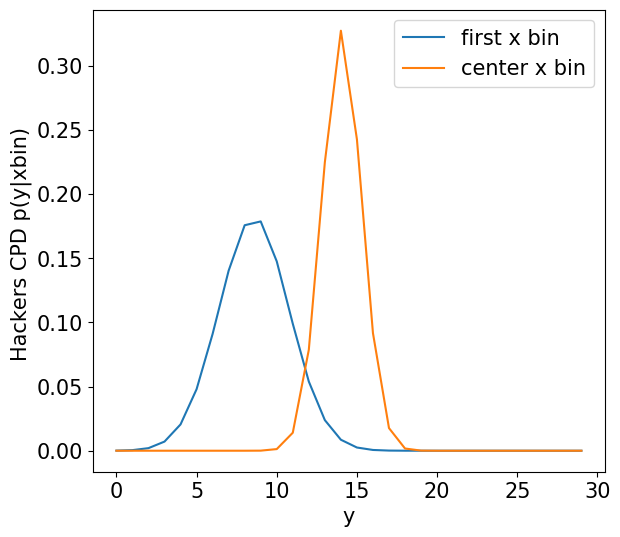

In [102]:
fig = plt.figure(figsize=(6.6,6))
plt.plot(pyx[:,(0,int(nbins/2))]) 
plt.xlabel('y')
plt.ylabel('p(y|x)')
locs, labels = plt.xticks()
plt.ylabel('Hackers CPD p(y|xbin) ')
plt.legend(['first x bin','center x bin'])
plt.savefig('ch07_f_mar_2.pdf')

<img src="https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/paper-pen.png" width="60" align="left" />  

Go back to the main text. The analytical solution below will be discussed in the last part of chapter 7.

# Analytical Solution 

For the special case that $\sigma$ is known there exists an analytic solution. For the analytical solution is is further assumed that the prios for a and b are both normally descributed (no correlation) with same spread of the prior distribution $\sigma_0$.

$$
    a \sim N(0,\sigma_0)
$$

$$
    b \sim N(0,\sigma_0)
$$

Without going into details, the analytical solution can be obtained using the following code. If you are interested the analytical details, they are derived in [Bishop Pattern Recognition and Machine Learning.](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf). There is also a blog post describing descriping the solution http://krasserm.github.io/2019/02/23/bayesian-linear-regression/.

In [90]:
def make_design_matrix(x):
    return np.hstack((np.ones((len(x),1)), x))

def posterior(x, y, one_over_var0, var):
    """
        x vector with training x data
        y vector with training y values
        one_over_var0 1/𝜎0^2 the variances of the prior distribution
        var is the assumed to be known variance of data
        @returns mean vector mu and covariance Matrix Sig 
    """
    X = make_design_matrix(x)
    Sig_inv = one_over_var0 * np.eye(X.shape[1]) + X.T.dot(X) / var
    Sig = np.linalg.inv(Sig_inv)
    mu = Sig.dot(X.T).dot(y) / var
    return mu, Sig

def posterior_predictive(x_test, mu, Sig, var):
    """
        x_test the positions, where the posterior is to be evaluated
        mu the mean values of the weight-posterior
        Sig the covariance matrix 
        var is the assumed to be known variance of data 
        Computes mean and variances of the posterior predictive distribution of y
    """
    X_test = make_design_matrix(x_test)
    y = X_test.dot(mu)
    # Only compute variances (diagonal elements of covariance matrix)
    y_var = var + np.sum(X_test.dot(Sig) * X_test, axis=1)  
    return y, y_var

## Comparison with the brute force solution

Let's first compare the posterior of the weights with the brute force solution. In this case we had a flat prior, which we can model by setting  `one_over_var0`=0

In [91]:
m, Sigma = posterior(x, y, 0.0, sigma**2)

In [92]:
print('Analytical Solution:\n mean (b,a):',m, '\n sigma:\n',Sigma)   
b_ml,a_ml

Analytical Solution:
 mean (b,a): [-1.72671247  2.92051026] 
 sigma:
 [[2.25000000e+00 1.12410081e-16]
 [1.12410081e-16 1.01250000e+00]]


(-1.726712471421449, array([2.92051026]))

#### Comparison with the brute force solution

To compare the brute force solution with the analytical. We calculate a slice of the brute-force unnormalized likelihood solution $l$ in $a$ at 250 support points `ass` with fixed $b=0$ (marginal likelihood). 

For normlization, we use

$$
  \int c \cdot l(a) da \approx \sum_i c \cdot l(a_i) \Delta = 1
$$

With $\Delta$ is the range of a divided by the number of support point.  

In [93]:
bb  = 0
aas = np.linspace(-2,8,250)
l = np.linspace(-2,8,250)
for i,a in enumerate(aas):
    l[i] = unnormalized_likehihood(tf.Variable([a,bb],dtype=tf.float32))

## Normalizing the likelihood
delta = 10./250.
c = 1 / np.sum(l*delta)
p = c*l # The normalized probability density evaluated at the support points 

p is now the density $l$ at the positions $a_i$. Hence,
$$
 1 = \sum p(a_i) \Delta 
$$

$$
 \sum a_i p(a_i) \Delta = mean 
$$


$$
 \sum (a_i - mean)^2 p(a_i) \Delta = var 
$$


In [94]:
np.sum(p * delta) #1 
mean = np.sum(aas * p * delta) 
print(mean)
var = np.sum((aas - mean)**2 * p * delta) 
print('var ', var, '  std ', np.sqrt(var))

2.9205115022755774
var  1.0124830177270003   std  1.0062221512802232


In [95]:
import pandas as pd
pd.DataFrame([[mean,m[1]],[var,Sigma[1,1]]],index=['mean(a)','var(a)'], columns=['Hacker','Analytical'])

,Hacker,Analytical
mean(a),2.920512,2.92051
var(a),1.012483,1.01250


Text(0.5, 1.0, 'Posterior for the slope (a)')

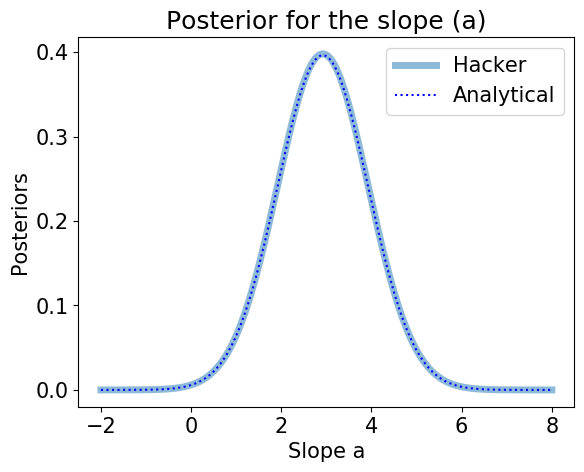

In [96]:
pana = np.linspace(-2,8,250)
i = 0
for i,a in enumerate(aas):
    oben = (a-m[1])**2
    unten = 2*Sigma[1,1]
    pana[i] = np.exp(-oben/unten) / np.sqrt(2*np.pi*Sigma[1,1])
    
plt.plot(aas, p, alpha=0.5,linewidth=5)
plt.plot(aas, pana,linestyle='dotted',c='b')
plt.xlabel('Slope a')
plt.ylabel('Posteriors')
plt.legend(['Hacker ', 'Analytical'])
plt.title('Posterior for the slope (a)')

### Comparison of the posteriori predictive distribution

Besides the posterior of the weights, we can also calculate the posterior predictive distribution. We evaluate the posteriori predictive distribution at many values between the xmin and the xmax, where we also evaluated before for the hackers way.

####  Some slices

[-1.72671247]


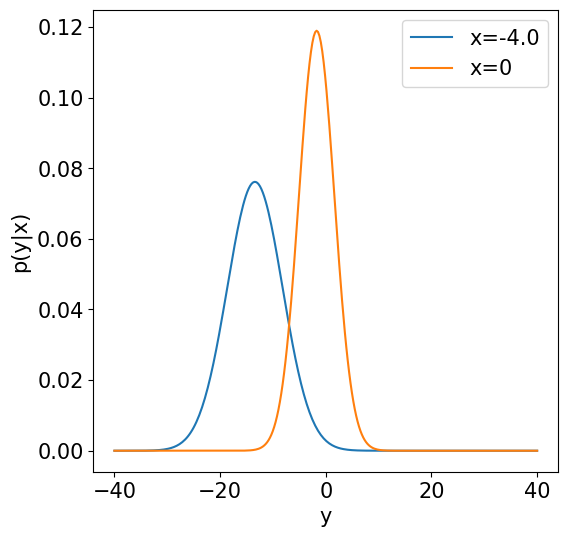

In [101]:
fig = plt.figure(figsize=(6,6))
ys = np.linspace(-40,40,300)

# The point at 4
y_mu, yt_var = posterior_predictive([[-4]], m, Sigma, sigma**2)
pys = scipy.stats.norm(loc=y_mu, scale=np.sqrt(yt_var)).pdf(ys) 
plt.plot(ys, pys)

# The point at 0
y_mu, yt_var = posterior_predictive([[0]], m, Sigma, sigma**2)
pys = scipy.stats.norm(loc=y_mu, scale=np.sqrt(yt_var)).pdf(ys) 
plt.plot(ys, pys)
print(y_mu)
plt.legend(['x=-4.0','x=0'])
plt.xlabel('y')
plt.ylabel('p(y|x)')
plt.savefig('ch07_slices_ana.pdf')

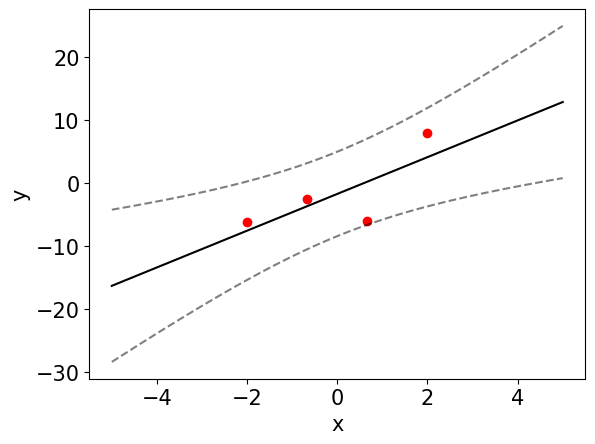

In [106]:
xs = np.linspace(xmin,xmax,250).reshape((250,1))
y_mu, yt_var = posterior_predictive(xs, m, Sigma, sigma**2)
y_mu[0], yt_var[0] 
ax = plt.gca()
plt.plot(xs, y_mu, color = 'black')
plt.plot(xs, y_mu + 2 * np.sqrt(yt_var),linestyle='dashed', alpha=0.5,color='black')
plt.plot(xs, y_mu - 2 * np.sqrt(yt_var),linestyle='dashed', alpha=0.5,color='black')
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(x,y,color='r')

<img src="https://as1.ftcdn.net/jpg/01/33/91/60/500_F_133916095_PS4juqjP6hNZvIHHT43ehNqlpRyqGDTV.jpg" width="300" align="left" />  